In [140]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
# load data
df = pd.read_csv('adult-small.csv')

In [142]:
# data cleaning
# check columns that have missing values
df.isin(['?']).sum(axis=0)

# replace missing values (?) to nan and then drop the columns 
df['native.country'] = df['native.country'].replace('?',np.nan)
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)

# #dropping the NaN rows now 
df.dropna(how='any',inplace=True)

In [143]:
# mapping the data into numerical data using map function
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df['sex'] = df['sex'].map({'Male': 0, 'Female': 1}).astype(int)
df['race'] = df['race'].map({'Black': 0, 'Asian-Pac-Islander': 1, 'Other': 2, 'White': 3, 'Amer-Indian-Eskimo': 4}).astype(int)
df['maritalStatus'] = df['marital.status'].map({'Married-spouse-absent': 0, 'Widowed': 1, 'Married-civ-spouse': 2, 'Separated': 3, 'Divorced': 4,'Never-married': 5, 'Married-AF-spouse': 6}).astype(int)
df['workclass'] = df['workclass'].map({'Self-emp-inc': 0, 'State-gov': 1,'Federal-gov': 2, 'Without-pay': 3, 'Local-gov': 4,'Private': 5, 'Self-emp-not-inc': 6, 'Never-worked':7}).astype(int)
df['occupation'] = df['occupation'].map({'Exec-managerial': 1, 'Machine-op-inspct': 2, 'Prof-specialty': 3, 'Other-service': 4, 'Adm-clerical': 5, 'Craft-repair': 6, 'Transport-moving': 7, 'Handlers-cleaners': 8, 'Sales': 9, 'Farming-fishing': 10, 'Tech-support': 11, 'Protective-serv': 12, 'Armed-Forces': 13, 'Priv-house-serv': 14}).astype(int)
df['relationship'] = df['relationship'].map({'Not-in-family': 0, 'Wife': 1, 'Other-relative': 2, 'Unmarried': 3,'Husband': 4,'Own-child': 5}).astype(int)
df['native.country'] = df['native.country'].map({'United-States': 0, 'Cambodia': 1, 'England': 2, 'Puerto-Rico': 3, 'Canada': 4, 'Germany': 5, 'Outlying-US(Guam-USVI-etc)': 6, 'India': 7, 'Japan': 8, 'Greece': 9, 'South': 10, 'China': 11, 'Cuba': 12, 'Iran': 13, 'Honduras': 14, 'Philippines': 15, 'Italy': 16, 'Poland': 17, 'Jamaica': 18, 'Vietnam': 19, 'Mexico': 20, 'Portugal': 21, 'Ireland': 22, 'France': 23, 'Dominican-Republic': 24, 'Laos': 25, 'Ecuador': 26, 'Taiwan': 27, 'Haiti': 28, 'Columbia': 29, 'Hungary': 30, 'Guatemala': 31, 'Nicaragua': 32, 'Scotland': 33, 'Thailand': 34, 'Yugoslavia': 35, 'El-Salvador': 36, 'Trinadad&Tobago': 37, 'Peru': 38, 'Hong': 39, 'Holand-Netherlands': 40}).astype(int)

In [144]:
# split data into train and test sets. 'stratify' to ensure similar distribution of class label in train and test data 
train, test = train_test_split(df, test_size=0.3, stratify=df['income'])

In [145]:
# convert probabilities to list
def prob_to_list(lr_probs):
    lr_probs_list = []
    for item in lr_probs:
        lr_probs_list.insert(len(lr_probs_list),item[0])
    return(lr_probs_list)

# check if parity holds in the data
def parity(X_test, protected, predictedOutcome, actualOutcome):
    AVG=X_test.groupby(protected)['prob'].mean()
    return(AVG[1]-AVG[0])

In [146]:
# logistic regression. Y=income, X=everything else
# X_train = train['education.num'] # no need for education if education.num is there
X_train = pd.DataFrame(np.c_[train['relationship'], train['education.num'], train['race'], train['occupation'], train['sex'], train['maritalStatus'], train['workclass']], columns = ['relationship','education','race','occupation','sex','marital','workclass'])
y_train = train['income']

#Initialize the logistic regression model
# reg = LogisticRegression()
reg = LogisticRegression()
reg.fit(X_train, y_train)

# # considering influence in linear regression
# X1 = X_train
# X2 = X_train.transpose()
# X3 = np.linalg.inv(X2 @ X1)

# X4 = X1 @ X3
# # computed above: X(X'X)^(-1)
# # X5 = X4 @ X2
# print(X3.shape)
# # print(X4 @ X1.transpose())
# # Compute leverage
# for i in range(len(X_train)):
#     x = X_train.iloc[i]
#     h = x.transpose() @ X3 @ x

LogisticRegression()

In [147]:
# Compute original parity on test data
X_test = pd.DataFrame(np.c_[test['relationship'], test['education.num'], test['race'], test['occupation'], test['sex'], test['maritalStatus'], test['workclass']], columns = ['relationship','education','race','occupation','sex','marital','workclass'])
y_test = test['income']
y_pred = reg.predict(X_test)  
lr_probs = reg.predict_proba(X_test) # prediction probabilities
X_test_prob = X_test.copy()
X_test_prob['prob'] = prob_to_list(lr_probs)
original_parity = parity(X_test_prob, 'sex', None, None)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Original parity:", original_parity)

Accuracy: 0.7485611510791367
Original parity: 0.23303124819476873


In [153]:
X_train = pd.DataFrame(np.c_[train['relationship'], train['education.num'], train['race'], train['occupation'], train['sex'], train['maritalStatus'], train['workclass']], columns = ['relationship','education','race','occupation','sex','maritalStatus','workclass'])
y_train = train['income']

# Further on, we fit decision tree on computed influences and saw 'married' (all kinds of) 'men' are the highest contributors on parity difference
# What happens if we remove married men?
# removeRows =  train[(train.sex == 0) & (train.maritalStatus != 5)].index # married, men
removeRows =  train[train.sex == 0].index # men
train_0 = train.drop(removeRows)

X_train = pd.DataFrame(np.c_[train_0['relationship'], train_0['education.num'], train_0['race'], train_0['occupation'], train_0['sex'], train_0['maritalStatus'], train_0['workclass']], columns = ['relationship','education','race','occupation','sex','maritalStatus','workclass'])
y_train = train_0['income']
reg = LogisticRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)  
lr_probs = reg.predict_proba(X_test) # prediction probabilities
X_test_prob = X_test.copy()
X_test_prob['prob'] = prob_to_list(lr_probs)
print("Parity after removing rows:", parity(X_test_prob, 'sex', None, None))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Parity after removing rows: 0.03251567353124374
Accuracy: 0.7050359712230215


In [65]:
# influence computation
X_train = pd.DataFrame(np.c_[train['relationship'], train['education.num'], train['race'], train['occupation'], train['sex'], train['marital.status'], train['workclass']], columns = ['relationship','education','race','occupation','sex','marital','workclass'])
y_train = train['income']

reg = LogisticRegression()
# retrain model by removing one row at a time; compute parity difference
# influence of each point computed as change in parity by removing the point
# +ve implies parity has decreased, 
# -ve implies parity has increased--> removing this point would reduce bias
infs = [] 
for i in range(0, len(X_train)):
    X_train_remove_one_row = X_train.drop(X_train.index[i])
    y_train_remove_one_row = y_train.drop(y_train.index[i])
    reg.fit(X_train_remove_one_row, y_train_remove_one_row)
    y_pred = reg.predict(X_test)
    lr_probs = reg.predict_proba(X_test)
    X_test_prob['prob'] = prob_to_list(lr_probs)
    # influence measured as difference of original parity on test data and that after retraining model 
    inf = original_parity-parity(X_test_prob, 'sex', None, None)
    print("influence of:"+ str(i)+" out of "+str(len(X_train)))
    print(inf)
    infs.insert(len(infs),inf)
    #print(compute_statistical_parity_difference(X_test, y_pred))

ValueError: could not convert string to float: 'Married-civ-spouse'

In [11]:
# Random forest regression on influence
# Build a random forest regression model learnt on X to predict Y values
# where Y = calculated influences
# The idea is to identify attributes or predicates most important for influence computation
norm_infs = infs.copy()
norm_infs = [float(i)*10000/sum(norm_infs) for i in norm_infs]
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train,norm_infs)
y_pred = regressor.predict(X_train)

[Text(1953.0, 1359.0, 'marital <= 1.5\nmse = 657.576\nsamples = 6484\nvalue = 1.542'),
 Text(976.5, 815.3999999999999, 'sex <= 0.5\nmse = 1746.679\nsamples = 236\nvalue = 21.228'),
 Text(488.25, 271.79999999999995, 'mse = 594.128\nsamples = 70\nvalue = -19.123'),
 Text(1464.75, 271.79999999999995, 'mse = 1256.576\nsamples = 166\nvalue = 38.243'),
 Text(2929.5, 815.3999999999999, 'relationship <= 1.5\nmse = 601.248\nsamples = 6248\nvalue = 0.799'),
 Text(2441.25, 271.79999999999995, 'mse = 1059.349\nsamples = 1778\nvalue = -3.364'),
 Text(3417.75, 271.79999999999995, 'mse = 409.398\nsamples = 4470\nvalue = 2.455')]

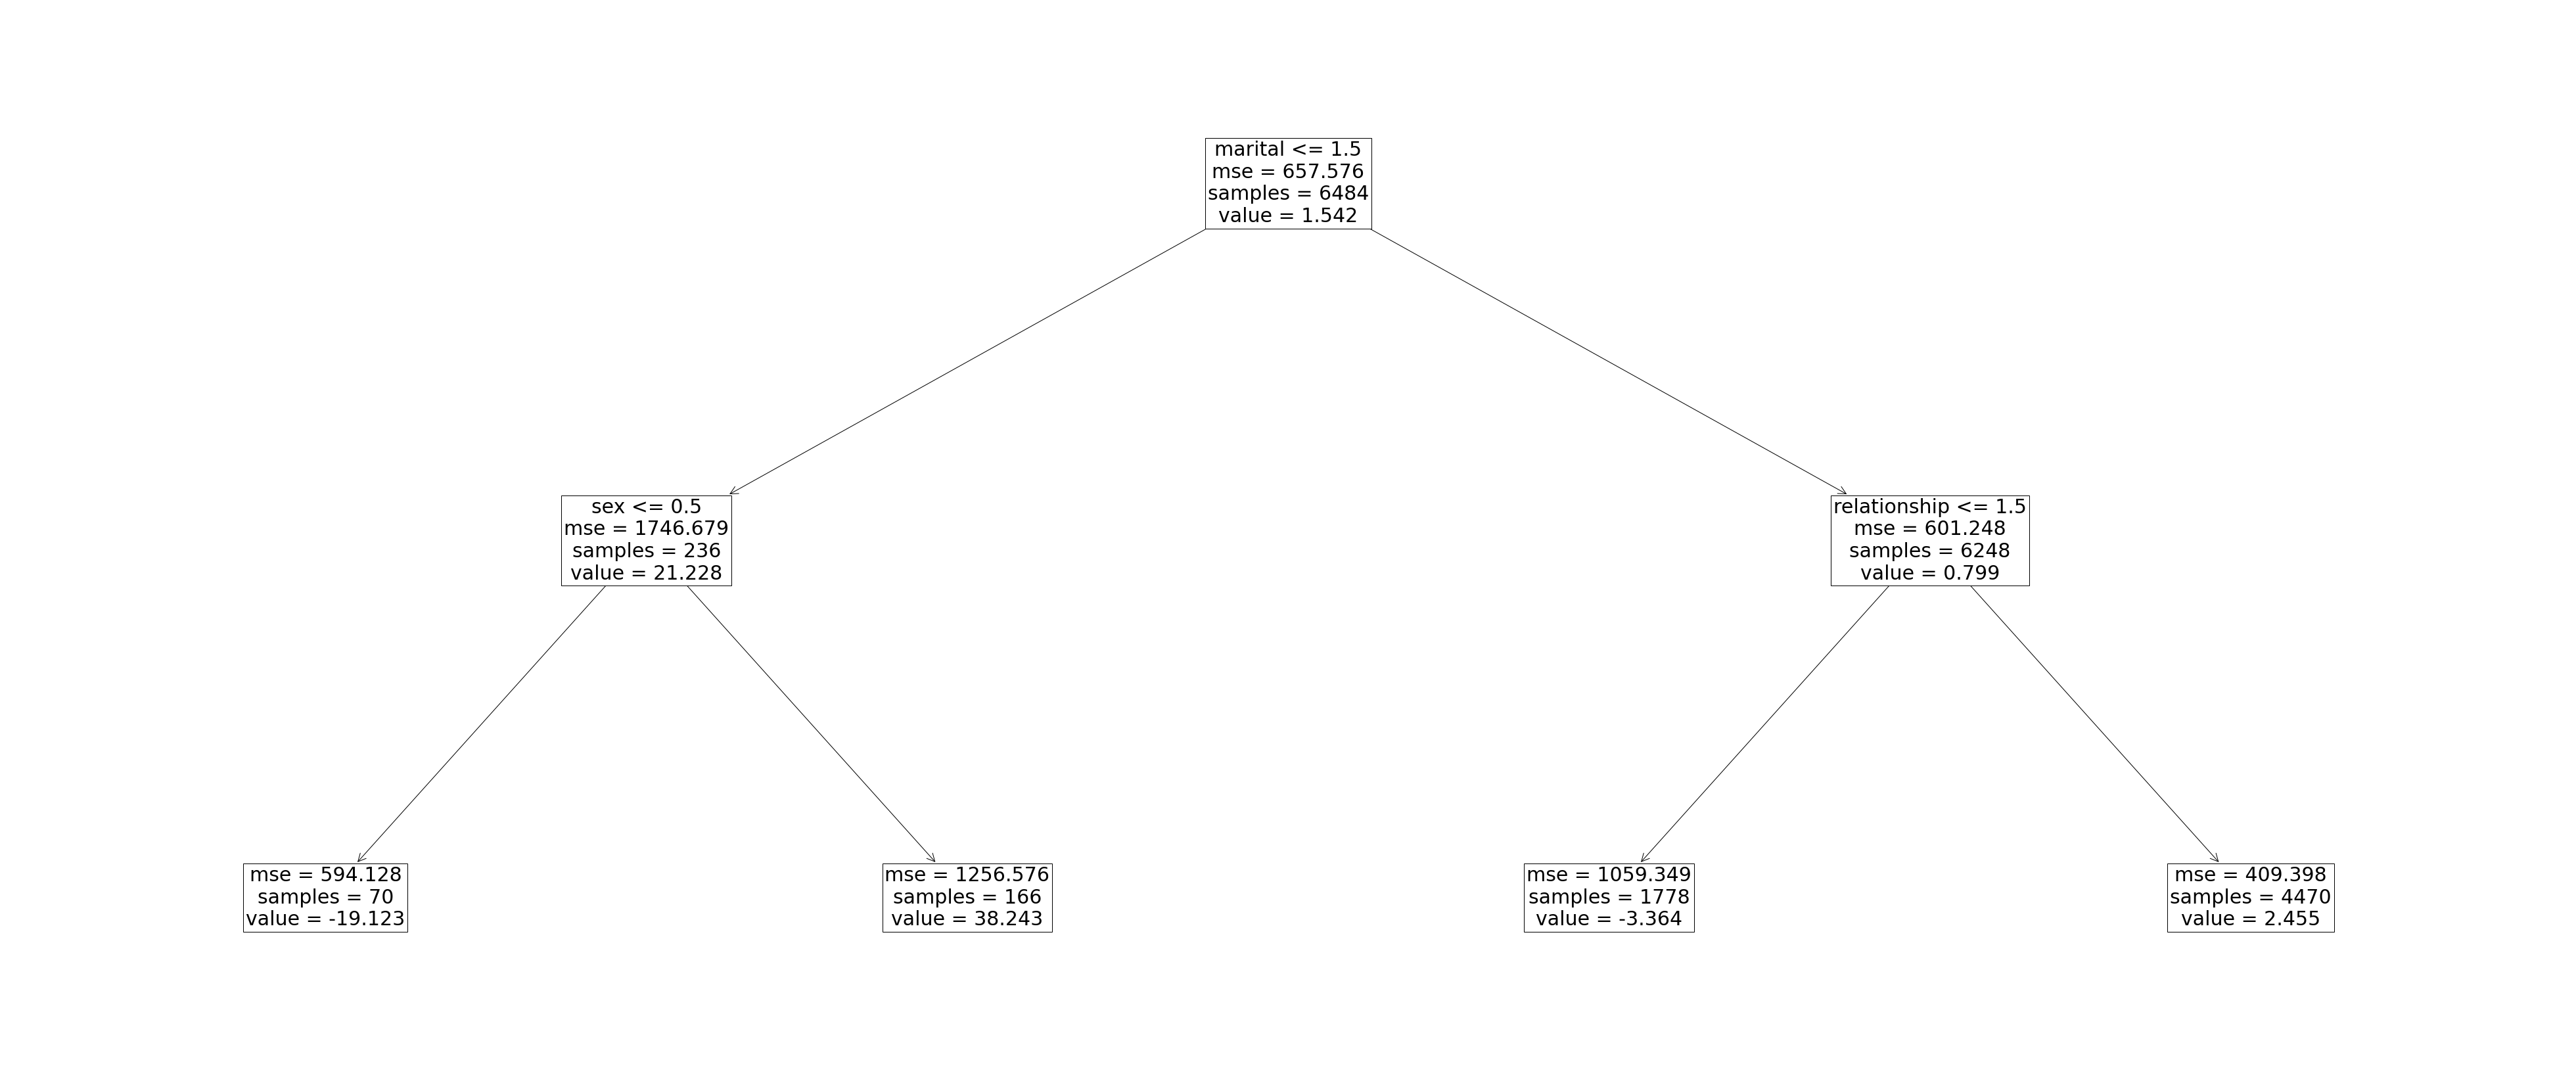

In [12]:
# Regression tree on influence
# where Y = calculated influences
# The idea is to identify attributes or predicates most important for influence computation
from sklearn.tree import DecisionTreeRegressor, plot_tree
regr_1 = DecisionTreeRegressor(max_depth=2) 
regr_1.fit(X_train,norm_infs)
plt.figure(figsize=(70,30))
plot_tree(regr_1,feature_names=X_train.columns,fontsize=30)

In [29]:
def xparity(X_test, protected, predictedOutcome, actualOutcome):
    #  # demographic parity (same as statistical parity?)
    # P(highIncome | Male) = P(highIncome | Female)
    AVG=X_test.groupby(protected)['prob'].mean()

    # conditional statistical parity
    # P(highIncome | Male, Married) = P(highIncome | Female, Married)
#     AVG=X_test.groupby(protected)['prob'].mean()


# equalized odds (both groups have the same false positive rate)
# P(highIncome | actual=0, Male) = P(highIncome | actual=0, Female)

# predictive parity (both groups have the same predicted positive value)
# P(actual=1 | highIncome, Male) = P(actual=1 | highIncome, Female) ?
    return(AVG[1]-AVG[0])

X_test = pd.DataFrame(np.c_[test['relationship'], test['education.num'], test['race'], test['occupation'], test['sex'], test['marital.status'], test['workclass']], columns = ['relationship','education','race','occupation','sex','marital','workclass'])
y_test = test['income']
y_pred = reg.predict(X_test)  
lr_probs = reg.predict_proba(X_test) # prediction probabilities
X_test_prob = X_test.copy()
X_test_prob['prob'] = prob_to_list(lr_probs)
X_test.groupby(['sex'])['race'].sum()
# xp = xparity(X_test_prob, ['sex',], None, None)
# print("Original parity:", xp)


sex
0    5387
1    2073
Name: race, dtype: int64